# Map/Reduce avec PIG sur cloudera - énoncé

Manipulation de fichiers sur un cluster Hadoop [Cloudera](https://www.cloudera.com/), premieer job map/reduce avec [PIG](https://pig.apache.org/). Lire aussi [From Pig to Spark: An Easy Journey to Spark for Apache Pig Developers](https://mapr.com/blog/easy-journey-from-pig-to-spark-for-developers/).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Données

On considère le jeu de données suivant : [Localization Data for Person Activity Data Set](https://archive.ics.uci.edu/ml/datasets/Localization+Data+for+Person+Activity) qu'on récupère comme suit :

In [2]:
import pyensae
import urllib.error
try:
    # ce soir ça ne marche pas...
    pyensae.download_data("ConfLongDemo_JSI.txt", 
                          website="https://archive.ics.uci.edu/ml/machine-learning-databases/00196/")
except urllib.error.URLError:
    # donc je récupère une vieille copie
    pyensae.download_data("ConfLongDemo_JSI.zip")

On l'insère dans une base de données SQL.

In [3]:
columns = "sequence tag timestamp dateformat x y z activity".split()
import pandas, sqlite3, os
df = pandas.read_csv("ConfLongDemo_JSI.txt", sep=",", names=columns)
if os.path.exists("ConfLongDemo_JSI.db3"):
    os.remove("ConfLongDemo_JSI.db3")
    
con = sqlite3.connect("ConfLongDemo_JSI.db3")
df.to_sql("person", con)
con.close()
df.head()

sequence              tag           timestamp               dateformat  \
0      A01  010-000-024-033  633790226051280329  27.05.2009 14:03:25:127   
1      A01  020-000-033-111  633790226051820913  27.05.2009 14:03:25:183   
2      A01  020-000-032-221  633790226052091205  27.05.2009 14:03:25:210   
3      A01  010-000-024-033  633790226052361498  27.05.2009 14:03:25:237   
4      A01  010-000-030-096  633790226052631792  27.05.2009 14:03:25:263   

          x         y         z activity  
0  4.062931  1.892434  0.507425  walking  
1  4.291954  1.781140  1.344495  walking  
2  4.359101  1.826456  0.968821  walking  
3  4.087835  1.879999  0.466983  walking  
4  4.324462  2.072460  0.488065  walking

On crée un petit exemple pour plus tard qu'on enregistre également dans la base de données.

In [4]:
columns = "sequence tag timestamp dateformat x y z activity".split()
import pandas
df = pandas.read_csv("ConfLongDemo_JSI.txt", sep=",", names=columns)
dfs = df[:1000]
dfs.to_csv("ConfLongDemo_JSI.small.txt", header=False)

import sqlite3
con = sqlite3.connect("ConfLongDemo_JSI.db3")
dfs.to_sql("person_small", con)
con.close()

In [5]:
[ _ for _ in os.listdir(".") if "db3" in _ ]

['ConfLongDemo_JSI.db3']

## Partie 0 : aperçu du cluster Teralab
    
Il faut se connecter au cluster avec l'url : ``https://....datascience.fr/....&login=<login>``.

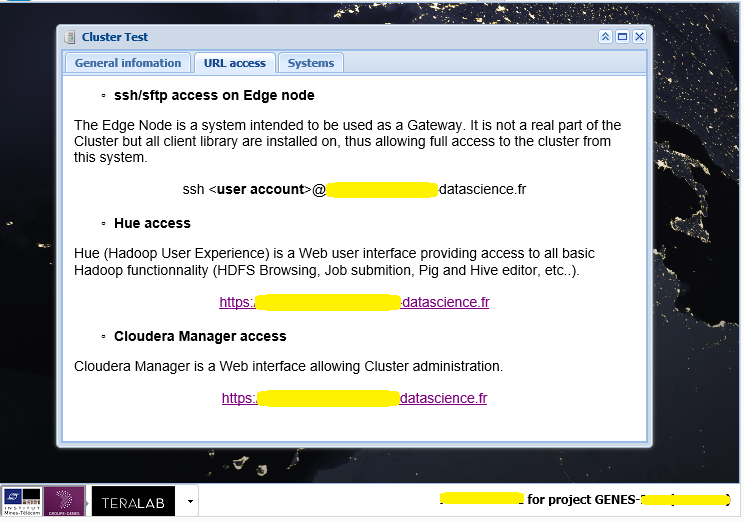

In [6]:
from pyquickhelper.helpgen import NbImage
NbImage("cluster1.png", width=500)

Il faut cliquer ensuite sur ``Hue Access`` une fenêtre s'ouvre. Il faut ensuie trouver l'onglet qui permette d'obtenir l'image suivante et le bouton ``Upload`` :

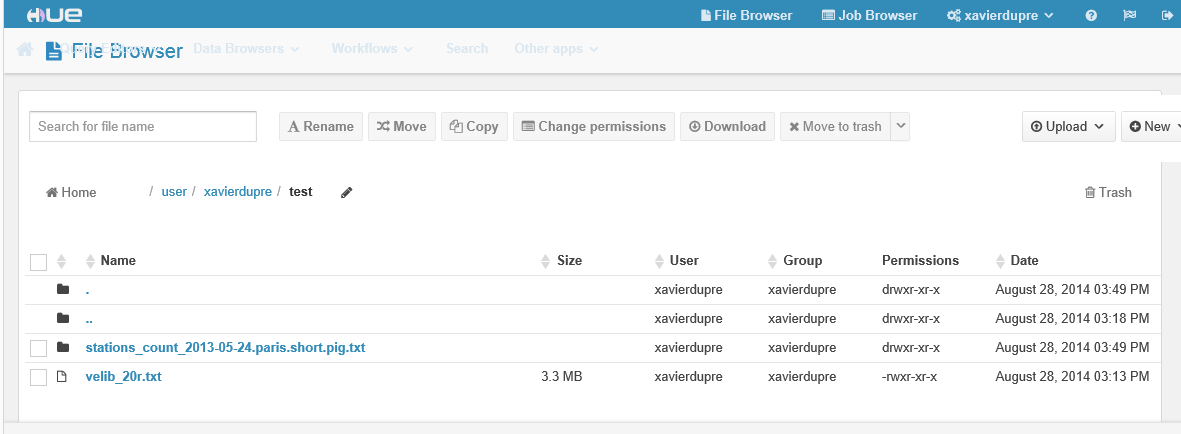

In [7]:
NbImage("hdfs1.png", width=900)

Les notebooks n'utiliseront que rarement cette interface qui est lente [Hue extremely slow in running Hive Queries](https://www.marshut.net/krrzvs/hue-extremely-slow-in-running-hive-queries.html), [hue is very slow](http://grokbase.com/p/cloudera/hue-user/141hmfp0w3/hue-is-very-slow).

## Partie 1 :  manipulation de fichiers

Avant de commencer à déplacer des fichiers, il faut comprendre qu'il y a trois emplacements :

* l'ordinateur local (celui dont vous vous servez)
* la machine distante ou [passerelle](http://fr.wikipedia.org/wiki/Passerelle_%28informatique%29)
* le cluster

Les fichiers vont transiter sans cesse par cette passerelle. La passerelle est connectée à l'ordinateur local via [SSH](http://fr.wikipedia.org/wiki/Secure_Shell).

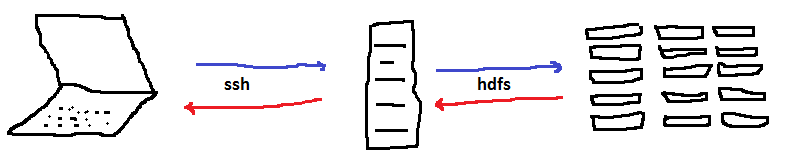

In [8]:
from pyquickhelper.helpgen import NbImage
NbImage("hdfspath.png")

On **uploade** pour le chemin bleu, on **downloade** pour le chemin rouge. La passerelle est sous linux et c'est par son intermédiaire qu'on va communiquer avec le cluster. Toutes les commandes qui suivent vont être exécutées depuis cette machine. L'outil le plus connu pour s'y connecter est [Putty](http://www.putty.org/). La commande magique ``%remote_cmd`` imite le comportement d'une fenêtre ``putty``.

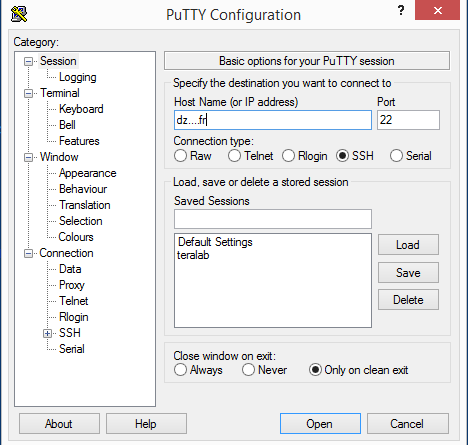

In [9]:
from pyquickhelper.helpgen import NbImage
NbImage("putty1.png", width=400)

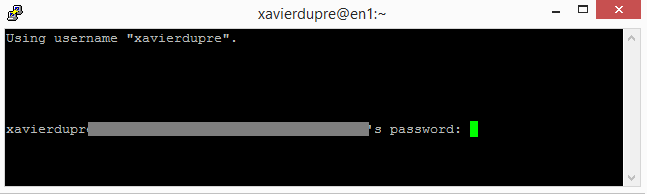

In [10]:
NbImage("putty2.png", width=600)

Le cluster [Hadoop](http://hadoop.apache.org/) inclut un système de fichiers [HDFS](http://hadoop.apache.org/docs/r1.2.1/hdfs_design.html). Celui fonctionne à peu près comme un système de fichiers linux avec les mêmes commandes à ceci près qu'un fichier n'est plus nécessaire localisé sur une seule machine mais peut-être réparti sur plusieurs. Pour éviter la perte de données due à des machines défaillantes, les données sont [répliquées trois fois](http://www.bigdataplanet.info/2013/10/Hadoop-Tutorial-Part-3-Replication-and-Read-Operations-in-HDFS.html). Les opérations standard sont disponibles (copy, rename, delete) auxquelles on ajoute deux opérations : upload, download. Les commandes sont presque identiques à celles de linux mais précédées de ``hdfs``.

Pour manipuler les données sur un cluster, il faut d'abord les [uploader](http://fr.wiktionary.org/wiki/uploader) sur ce cluster. Pour les récupérer, il faut les [downloader](http://fr.wikipedia.org/wiki/T%C3%A9l%C3%A9chargement). Pour faciliter les choses, on va utiliser des [commandes magiques](http://ipython.org/ipython-doc/dev/interactive/magics.html?highlight=command) implémentées dans le module [pyensae](http://www.xavierdupre.fr/app/pyensae/helpsphinx/) (>= 0.8). La première tâche est d'enregistrer dans l'espace de travail le nom du server, votre alias et votre mot de passe dans le workspace du notebook.

Le code est avant tout destiné à **ne pas laisser votre mot de passe en clair dans le notebook**. S'il est en clair, tôt ou tard, vous oublierez de l'effacer avant de partager votre notebook. Dans ce cas, il faut changer de mot de passe sans tarder.

Le code suivant vérifie d'abord qu'il n'existe pas de variable d'environnement ``CRTERALAB`` afin de ne pas avoir à rentrer les mot de passe à chaque fois (voir [Mettre ses mots de passe dans les variables d’environnement](http://www.xavierdupre.fr/app/ensae_projects/helpsphinx/projects/hackathon_2015_startup.html#mettre-ses-mots-de-passe-dans-les-variables-d-environnement)). Si cette variable existe, le notebook s'attend à trouver l'information ``server**password**username``.

In [11]:
import os
if "CRTERALAB" in os.environ:
    spl = os.environ["CRTERALAB"].split("**")
    params=dict(server=spl[0], password=spl[1], username=spl[2])
    r = dict
else:
    from pyquickhelper.ipythonhelper import open_html_form
    params={"server":"", "username":"", "password":""}
    r = open_html_form(params=params,title="server + credentials", key_save="params")
r

dict

On stocke le mot de passe dans trois variables de l'espace de travail afin que les commandes magiques trouvent ces informations.

In [12]:
password = params["password"]
server = params["server"]
username = params["username"]

On ouvre la connection SSH qui restera ouverte jusqu'à ce qu'on la ferme.

In [13]:
%load_ext pyensae
%load_ext pyenbc
%remote_open

On regarde le contenu du répertoire qui vous est associé sur la machine distante :

In [14]:
%remote_cmd ls -l

On efface tout :

In [15]:
%remote_cmd rm -r *

In [16]:
%remote_cmd ls -l

C'est une commande linux. Les commandes les plus fréquentes sont accessibles décrites à [Les commandes de base en console](http://doc.ubuntu-fr.org/tutoriel/console_commandes_de_base). L'instruction suivante consiste à uploader un fichier depuis l'ordinateur local vers la passerelle.

In [17]:
%remote_up ConfLongDemo_JSI.small.txt ConfLongDemo_JSI.small.example.txt

'ConfLongDemo_JSI.small.example.txt'

On vérifie que celui-ci a bien été transféré :

In [18]:
%remote_cmd ls -l

Ensuite, on regarde le contenu du répertoire qui vous est associé sur le cluster :

In [19]:
%remote_cmd hdfs dfs -ls

On supprime les précédentes exécutions :

In [20]:
%remote_cmd hdfs dfs -rm -f -R ConfLong*

In [21]:
%remote_cmd hdfs dfs -ls 

Les commandes HDFS décrite à [Apache Hadoop 2.3.0](http://hadoop.apache.org/docs/r2.3.0/hadoop-project-dist/hadoop-common/FileSystemShell.html). Elles sont très proches des commandes linux. Ensuite, on uploade le fichier sur le système de fichier distribué du cluster (HDFS) :

In [22]:
%remote_cmd hdfs dfs -put ConfLongDemo_JSI.small.example.txt ./ConfLongDemo_JSI.small.example.txt

Puis on vérifie que le fichier a bien été uploadé sur le cluster :

In [23]:
%remote_cmd hdfs dfs -ls

On regarde la fin du fichier sur le cluster :

In [24]:
%remote_cmd hdfs dfs -tail ConfLongDemo_JSI.small.example.txt

Le fichier va suivre maintenant le chemin inverse. On le rapatrie depuis le cluster jusqu'à l'ordinateur local. Première étape : du cluster à la passerelle :

In [25]:
%remote_cmd hdfs dfs -get ConfLongDemo_JSI.small.example.txt ConfLongDemo_JSI.small.example.is_back.txt

On vérifie que le fichier est sur la passerelle :

In [26]:
%remote_cmd ls -l

On supprime le fichier de la précédente exécution :

In [27]:
import os
if os.path.exists("ConfLongDemo_JSI.small.example.is_back_local.txt") : 
    os.remove("ConfLongDemo_JSI.small.example.is_back_local.txt")

In [28]:
[ _ for _ in os.listdir(".") if "txt" in _ ]

['ConfLongDemo_JSI.small.txt', 'ConfLongDemo_JSI.txt']

Second transfert depuis la passerelle jusqu'à l'ordinateur local :

In [29]:
%remote_down ConfLongDemo_JSI.small.example.is_back.txt ConfLongDemo_JSI.small.example.is_back_local.txt

'ConfLongDemo_JSI.small.example.is_back_local.txt'

In [30]:
[ _ for _ in os.listdir(".") if "txt" in _ ]

['ConfLongDemo_JSI.small.example.is_back_local.txt',
 'ConfLongDemo_JSI.small.txt',
 'ConfLongDemo_JSI.txt']

In [31]:
%remote_close

True

## Partie 2 : premier job map/reduce avec PIG

Pour cette partie, l'idée d'exécuter des jobs Map/Reduce sur le fichier ``ConfLongDemo_JSI.small.example.txt`` puis de vérifier qu'on obtient bien les même résultats sur le même fichier en utilisant une requête SQL. Le code pour créer la connexion à la passerelle est recopié ci-dessous mais il n'est pas nécessaire de l'exécuter si la connexion n'a pas été interrompue.

In [32]:
import pyensae
from pyquickhelper.ipythonhelper import open_html_form
open_html_form(params=params,title="server + credentials", key_save="params")

In [33]:
password = params["password"]
server = params["server"]
username = params["username"]

In [34]:
ssh = %remote_open
ssh

<h4 id="job">JOBS</h4>

Un job définit l'ensemble des traitements que vous souhaitez effectuer sur un ou plusieurs fichiers. Le langage [PIG](http://pig.apache.org/docs/r0.12.1/basic.html) permet de décrire ces traitements. Le programme est ensuite interprété puis soumis à Hadoop qui s'occupe de répartir de traitements sur l'ensemble des resources dont il dispose. La commande suivante permet d'obtenir l'ensemble des tâches associés aux jobs :

In [35]:
%remote_cmd mapred --help

Et plus spécifiquement pour la commande ``mapred job`` :

    Usage: CLI <command> <args>
        [-submit <job-file>]
        [-status <job-id>]
        [-counter <job-id> <group-name> <counter-name>]
        [-kill <job-id>]
        [-set-priority <job-id> <priority>]. Valid values for priorities are: VERY_HIGH HIGH NORMAL LOW VERY_LOW
        [-events <job-id> <from-event-#> <#-of-events>]
        [-history <jobHistoryFile>]
        [-list [all]]
        [-list-active-trackers]
        [-list-blacklisted-trackers]
        [-list-attempt-ids <job-id> <task-type> <task-state>]. Valid values for <task-type> are REDUCE MAP. Valid values for <task-state> are running, completed
        [-kill-task <task-attempt-id>]
        [-fail-task <task-attempt-id>]
        [-logs <job-id> <task-attempt-id>]
    

D'autres commandes sont disponibles avec la commande ``pig`` :

In [36]:
%remote_cmd pig --help

Le job suit le processus suivant :
    
* Le job est soumis à Hadoop.
* Il est ensuite placé dans une file d'attente avec une priorité qui détermine son ordre d'exécution (**queue**).
* Il est exécuté.

<h4 id="select">SELECT ... WHERE</h4>

In [37]:
import sqlite3
con = sqlite3.connect("ConfLongDemo_JSI.db3")

import pandas.io.sql as psql
sql = 'SELECT * FROM person_small WHERE activity == "walking"'
df = psql.read_sql(sql, con)
con.close()
df.tail()

index sequence              tag           timestamp  \
165    698      A01  010-000-030-096  633790226277429870   
166    699      A01  020-000-032-221  633790226277970452   
167    700      A01  010-000-024-033  633790226278240749   
168    701      A01  020-000-033-111  633790226278781331   
169    702      A01  020-000-032-221  633790226279051629   

                  dateformat         x         y         z activity  
165  27.05.2009 14:03:47:743  2.965434  1.782434  0.228563  walking  
166  27.05.2009 14:03:47:797  4.322405  1.571452  1.400499  walking  
167  27.05.2009 14:03:47:823  3.133065  1.769329 -0.022590  walking  
168  27.05.2009 14:03:47:877  3.121254  1.549842  1.048139  walking  
169  27.05.2009 14:03:47:907  3.281498  1.498734  0.620412  walking

Avec [PIG](http://en.wikipedia.org/wiki/Pig_Latin) ([syntaxe](http://pig.apache.org/docs/r0.12.0/basic.html)), le programme inclut trois étapes :

* la déclaration de l'entrée (le fichier ``ConfLongDemo_JSI.small.example.txt``) (voir [LOAD](https://pig.apache.org/docs/r0.9.1/basic.html#load))
* la tâche à proprement parler (voir [FILTER](https://pig.apache.org/docs/r0.9.1/basic.html#filter))
* la création de la sortie (le fichier ``ConfLongDemo_JSI.small.example.walking.txt``) (voir [STORE](https://pig.apache.org/docs/r0.9.1/basic.html#store))

La commande magique permet d'écrire un fichier ``select1.pig`` avec l'encoding ``utf-8`` (les caractères accentuées sont possibles).

In [38]:
%%PIG select1.pig

myinput = LOAD 'ConfLongDemo_JSI.small.example.txt' USING PigStorage(',') AS 
    (index:long, sequence, tag, timestamp:long, dateformat, x:double,y:double, z:double, activity) ;
filt = FILTER myinput BY activity == "walking" ;

STORE filt INTO 'ConfLongDemo_JSI.small.example.walking_test.txt' USING PigStorage() ;

La commande suivante uploade le script et vérifie sa syntaxe (commande ``pig -check <jobname>``) :

In [39]:
%job_syntax select1.pig

Les guillemets ne font pas partie de la syntaxe du langage :

In [40]:
%%PIG select2.pig

myinput = LOAD 'ConfLongDemo_JSI.small.example.txt' 
          using PigStorage(',') 
          AS (index:long, sequence, tag, timestamp:long, dateformat, x:double,y:double, z:double, activity) ;

filt = FILTER myinput BY activity == 'walking' ;

STORE filt INTO 'ConfLongDemo_JSI.small.example2.walking_test20.txt' USING PigStorage() ;

La commande suivante fait deux choses : elle uploade le job sur la passerelle et le soumet via la commande ``pig -execute -f <filenme>``. S'il n'y a pas d'erreur, il rejoint la file d'attente.

In [41]:
%pig_submit select2.pig -r None

Derrière cette command magique, il y a la fonction [pig_submit](http://www.xavierdupre.fr/app/pyensae/helpsphinx/pyensae/remote/ssh_remote_connection.html?highlight=pig_submit#pyensae.remote.ssh_remote_connection.ASSHClient.pig_submit).

In [42]:
help(ssh.pig_submit)

Help on method pig_submit in module pyensae.remote.ssh_remote_connection:

pig_submit(pig_file, dependencies=None, params=None, redirection='redirection.pig', local=False, stop_on_failure=False, check=False, no_exception=True, fLOG=<function noLOG at 0x000000000573E620>) method of pyensae.remote.ssh_remote_connection.ASSHClient instance
    submits a PIG script, it first upload the script
    to the default folder and submit it
    
    @param      pig_file        pig script (local)
    @param      dependencies    others files to upload (still in the default folder)
    @param      params          parameters to send to the job
    @param      redirection     string empty or not
    @param      local           local run or not (option `-x local <https://cwiki.apache.org/confluence/display/PIG/PigTutorial>`_)  (in that case, redirection will be empty)
    @param      stop_on_failure if True, add option ``-stop_on_failure`` on the command line
    @param      check           if True, add 

On retrouve bien les mêmes résultats. Cependant, on n'a pas envie d'attendre la fin d'un job pour reprendre la main sur le notebook. Pour ce faire, on crée un second job.

In [43]:
%%PIG select3.pig

myinput = LOAD 'ConfLongDemo_JSI.small.example.txt' 
          using PigStorage(',') 
          AS (index:long, sequence, tag, timestamp:long, dateformat, x:double,y:double, z:double, activity) ;

filt = FILTER myinput BY activity == 'walking' ;

STORE filt INTO 'ConfLongDemo_JSI.small.example2.walking_test30_nowait.txt' USING PigStorage() ;

In [44]:
%pig_submit select3.pig

In [45]:
%remote_cmd tail redirection.pig.err -n 15

On vérifie le contenu du cluster :

In [46]:
%remote_cmd hdfs dfs -ls 

La sortie n'est pas un fichier mais un répertoire. Chaque partie provient d'une machine différente. Dans notre cas, les données étant de petite taille le calcul n'a pas été distribué.

In [47]:
%remote_cmd hdfs dfs -tail ConfLongDemo_JSI.small.example2.walking.txt/part-m-00000

On retrouve bien les mêmes résultats. Cependant, on n'a pas envie d'attendre la fin d'un job pour reprendre la main sur le notebook. Pour ce faire, on crée un second job.

On regarde la liste des jobs en cours avec [hadoop queue](http://hadoop.apache.org/docs/r1.0.4/commands_manual.html#queue) :

In [48]:
%remote_cmd hadoop queue -info root.xavierdupre -showJobs

In [49]:
%remote_cmd hdfs dfs -ls ConfLongDemo_JSI.small.example2.walking_test30_nowait.txt

C'est plus pratique mais la correction des erreurs quand elles se produisent n'est plus aussi pratique. On termine par une instruction qui permet de récupérer tous les fichiers d'un même repértoire en une seule fois :

In [50]:
%remote_cmd hdfs dfs -getmerge ConfLongDemo_JSI.small.example2.walking_test30_nowait.txt toutenun.txt

Le fichier est maintenant sur la passerelle.

In [51]:
%remote_cmd ls -l tout*

Lorsqu'on lance des jobs conséquent, il est important de savoir comment les arrêter avec [hadoop job](http://hadoop.apache.org/docs/r1.0.4/commands_manual.html#job) ``-kill jobid`` :

In [52]:
%remote_cmd hadoop job -list all

On peut tuer un job lorsqu'il est dans la file d'attente ou en train de s'exécuter.

In [53]:
#%remote_cmd hadoop job -kill job_1414491244634_0002

## Partie 3 : syntaxe PIG et exercices

Dans cette partie, l'objectif est de transcrire un ``GROUP BY`` en PIG, un ``JOIN`` et de combiner toutes ces opérations en un seul job au cours du second exercice. Ces exemples utilisent de petits fichiers. Utiliser un job Map/Reduce n'a pas beaucoup d'intérêt à moins que la taille de ces fichiers n'atteigne un giga-octets. Les instructions sont à chercher dans cette page : [Pig Latin Basics](http://pig.apache.org/docs/r0.12.0/basic.html).

### Exercice 1 : GROUP BY

In [54]:
import pandas, sqlite3
con = sqlite3.connect("ConfLongDemo_JSI.db3")
df = pandas.read_sql("""SELECT activity, count(*) as nb FROM person GROUP BY activity""", con)
con.close()
df.head()

activity     nb
0       falling   2973
1         lying  54480
2    lying down   6168
3  on all fours   5210
4       sitting  27244

Il faut maintenant le faire avec PIG.

### Exercice 2 : JOIN

In [56]:
con = sqlite3.connect("ConfLongDemo_JSI.db3")
df = pandas.read_sql("""SELECT person.*, A.nb FROM person INNER JOIN (
                            SELECT activity, count(*) as nb FROM person GROUP BY activity) AS A
                            ON person.activity == A.activity""", con)
con.close()
df.head()

index sequence              tag           timestamp  \
0      0      A01  010-000-024-033  633790226051280329   
1      1      A01  020-000-033-111  633790226051820913   
2      2      A01  020-000-032-221  633790226052091205   
3      3      A01  010-000-024-033  633790226052361498   
4      4      A01  010-000-030-096  633790226052631792   

                dateformat         x         y         z activity     nb  
0  27.05.2009 14:03:25:127  4.062931  1.892434  0.507425  walking  32710  
1  27.05.2009 14:03:25:183  4.291954  1.781140  1.344495  walking  32710  
2  27.05.2009 14:03:25:210  4.359101  1.826456  0.968821  walking  32710  
3  27.05.2009 14:03:25:237  4.087835  1.879999  0.466983  walking  32710  
4  27.05.2009 14:03:25:263  4.324462  2.072460  0.488065  walking  32710

Idem, maintenant il faut le faire avec PIG.